**Predicting Pool Violations with Decision Tree**

This project will use the DOHMH Pool Inspections dataset from NYC Opendata. 

Link: https://data.cityofnewyork.us/Health/DOHMH-Pool-Inspections/3kfa-rvez 

The data in this dataset was provided by: Department of Health and Mental Hygiene, Office of Public Health Engineering (DOHMH)

According to the user guide available in the webpage's attachments: 
In NYC, a permit is required to construct or operate bathing establishments with pools (including Saunas, Steam Rooms, Spray Grounds)
whether they're owned by city agencies, public/private schools, corporations, hotels, motels, camps, apartments, condominiums, clubs, gyms, etc.

This dataset contains data for 1,267 pool inspections for the year 2019, including location data like borough, zip code, district, indoor/outdoor, longitude, latitude, the number of violations, and others.

The question that this project will attempt to answer is:

Can we estimate how many critical violation pools will have depending on their location?

I will attempt to answer this question using decision tree classification. Different combinations of features will be used to build decision trees to see which combination yields the most accurate predictions.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split

# Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# to stabilize notebook output across runs
np.random.seed(42)

from sklearn.tree import DecisionTreeClassifier

from graphviz import Source
from sklearn.tree import export_graphviz

# setting up a directory to save figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
# later, the figures made in this in this notebook (decision tree images) can be found in files >> images >> decision trees

In [2]:
# fetching the csv file
!curl https://data.cityofnewyork.us/api/views/3kfa-rvez/rows.csv?accessType=DOWNLOAD -o pool_inspections.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  495k    0  495k    0     0   178k      0 --:--:--  0:00:02 --:--:--  178k


In [3]:
# turning the csv file into a dataframe
df = pd.read_csv("pool_inspections.csv")
df.head(3)

,Permit_Type,ACCELA,Facility_Name,ADDRESS_ No,ADDRESS_St,BO,ZIP,Inspection_Date,Inspection_Type,# of All Violations,...,DOCKET,Lat,Long,Community Board,Council District,Census tract,Boro-Block-Lot,BIN,NTA,NTA Code
0,Indoor,41576475,SPA 88 LLC,88,FULTON STREET,MA,10038,01/02/2019,Routine Inspection,6,...,00060-19S0,40.709291,-74.005944,101.0,1.0,1502.0,1.000770e+09,1077403.0,Battery Park City-Lower Manhattan,MN25
1,Indoor,50052652,WEST 30TH HL LLC,520,WEST 30 STREET,MA,10001,01/02/2019,Routine Inspection,1,...,NaN,40.752579,-74.002252,104.0,3.0,9900.0,1.007010e+09,1089836.0,Hudson Yards-Chelsea-Flatiron-Union Square,MN13
2,Indoor,50039431,XSPORT FITNESS,200,BAYCHESTER AVENUE,BX,10475,01/02/2019,Complaint Re-inspection,0,...,NaN,40.865905,-73.830430,210.0,12.0,46201.0,2.051410e+09,2120098.0,Co-op City,BX13


In [4]:
df.columns

Index(['Permit_Type', 'ACCELA', 'Facility_Name', 'ADDRESS_ No', 'ADDRESS_St',
       'BO', 'ZIP', 'Inspection_Date', 'Inspection_Type',
       '# of All Violations', '# of PHH Violations',
       '# of Critical Violations', '# of General Violations', 'DOCKET', 'Lat',
       'Long', 'Community Board', 'Council District', 'Census tract',
       'Boro-Block-Lot', 'BIN', 'NTA', 'NTA Code'],
      dtype='object')

In [6]:
# keeping only the columns of interest
df = df[['Permit_Type', 'BO', 'ZIP', 'Lat', 'Long', '# of Critical Violations']] 
# using 'X' & 'Y' instead of 'Lat' & 'Long' because to prevent errors from negative values & values with long decimals
df

,Permit_Type,BO,ZIP,Lat,Long,# of Critical Violations
0,Indoor,MA,10038,40.709291,-74.005944,3
1,Indoor,MA,10001,40.752579,-74.002252,0
2,Indoor,BX,10475,40.865905,-73.830430,0
3,Indoor,BX,10461,40.851176,-73.844821,0
4,Indoor,QU,11471,40.679631,-73.837298,1
...,...,...,...,...,...,...
2491,Indoor,MA,10014,40.740107,-74.005961,0
2492,Indoor,MA,10016,40.748396,-73.974711,0
2493,Indoor,MA,10024,40.775601,-73.982149,0
2494,Indoor,QU,11103,40.764208,-73.915661,1


In [7]:
# need to create a numeric columns for Permit_Type & BO, because the decision tree does not accept strings
df['PType_Code'] = df['Permit_Type'].map({'Indoor':1,'Outdoor':2})
df['Borough_Code'] = df['BO'].map({'BX':1, 'BK':2, 'MA':3, 'QU':4, 'SI':5})

<ipython-input-7-bc6c056af730>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PType_Code'] = df['Permit_Type'].map({'Indoor':1,'Outdoor':2})
<ipython-input-7-bc6c056af730>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Borough_Code'] = df['BO'].map({'BX':1, 'BK':2, 'MA':3, 'QU':4, 'SI':5})


In [9]:
df = df[['Permit_Type', 'PType_Code', 'BO', 'Borough_Code', 'ZIP', 'Lat', 'Long', '# of Critical Violations']]
df

,Permit_Type,PType_Code,BO,Borough_Code,ZIP,Lat,Long,# of Critical Violations
0,Indoor,1,MA,3,10038,40.709291,-74.005944,3
1,Indoor,1,MA,3,10001,40.752579,-74.002252,0
2,Indoor,1,BX,1,10475,40.865905,-73.830430,0
3,Indoor,1,BX,1,10461,40.851176,-73.844821,0
4,Indoor,1,QU,4,11471,40.679631,-73.837298,1
...,...,...,...,...,...,...,...,...
2491,Indoor,1,MA,3,10014,40.740107,-74.005961,0
2492,Indoor,1,MA,3,10016,40.748396,-73.974711,0
2493,Indoor,1,MA,3,10024,40.775601,-73.982149,0
2494,Indoor,1,QU,4,11103,40.764208,-73.915661,1


In [10]:
df.dtypes

Permit_Type                  object
PType_Code                    int64
BO                           object
Borough_Code                  int64
ZIP                           int64
Lat                         float64
Long                        float64
# of Critical Violations      int64
dtype: object

In [11]:
# removing NaN values
df = df.dropna()
# removing duplicates
df = df.drop_duplicates()

df.shape

(1275, 8)

In [12]:
df['# of Critical Violations'].value_counts() # checking distributions of possible labels

0    901
1    269
2     80
3     18
4      6
5      1
Name: # of Critical Violations, dtype: int64

In [13]:
# changing the target column into strings so that they can be used as labels
df['# of Critical Violations'] = df['# of Critical Violations'].astype(str)

In [14]:
# setting the features to be used for the following decision tree classification
features_1 = ['Lat', 'Long'] # starting with the two most precise features
target = ['# of Critical Violations']

In [15]:
X = df[features_1].values # isolating the data of the features
y = df[target].values # isolating the data of the target of prediction

In [16]:
y = y.ravel() # turning y from a two dimensional array to a one dimensional array
y

array(['3', '0', '0', ..., '0', '0', '1'], dtype=object)

In [17]:
# splitting data into training & testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1) # splitting into training & testing (4:1)

In [18]:
print('training dataset (X_train):', X_train.shape, '\ntesting dataset: (X_test)', X_test.shape, 
      '\ntraining labels: (y_train)', y_train.shape, '\ntesting labels: (y_test)', y_test.shape)

training dataset (X_train): (1020, 2) 
testing dataset: (X_test) (255, 2) 
training labels: (y_train) (1020,) 
testing labels: (y_test) (255,)


In [19]:
from sklearn.tree import DecisionTreeClassifier

desi_tree_1 = DecisionTreeClassifier(max_depth=6, random_state=42) 
desi_tree_1.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=42)

In [20]:
y_unique = np.unique(y) # to get an array of unique labels

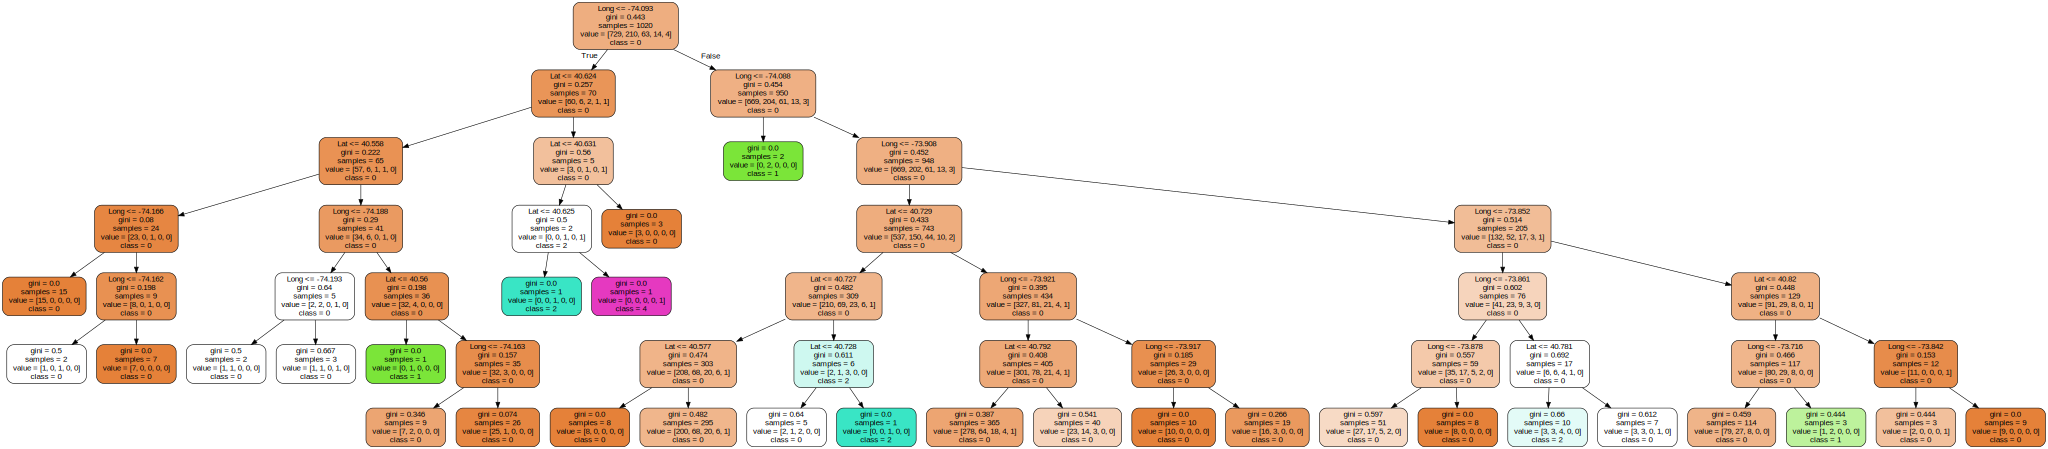

In [21]:
# creating a decision tree img file in a folder
export_graphviz(
        desi_tree_1,
        out_file=os.path.join(IMAGES_PATH, "pool_tree_1.dot"),
        feature_names = features_1,
        class_names = y_unique,
        rounded=True,filled=True)

Source.from_file(os.path.join(IMAGES_PATH, "pool_tree_1.dot"))

In [22]:
# making predictions using the testing dataset
predictions = desi_tree_1.predict_proba(X_test)
predictions[212]

array([0.76164384, 0.17534247, 0.04931507, 0.0109589 , 0.00273973])

In [23]:
predictions_list = []
for i in predictions:
  predictions_list.append(list(i).index(i.max())) # getting the index of the class with the highest probability

In [24]:
# turning the list of predictions into strings so that it can be compared with the test labels
predictions_list = [str(i) for i in predictions_list]
#predictions_list

In [25]:
comparison = []
for (i, j) in zip(list(y_test), predictions_list):
  #print(i, j)
  if i == j:
    comparison.append(1)
  else:
    comparison.append(0)

In [26]:
# finding the percentage correct out of all the predictions
result_1 = sum(comparison)/len(comparison)
print(result_1)

0.6392156862745098


A percentage of 0.64 is not very good. Will try using other features to train the decision tree:

In [27]:
# turning some of the above steps into a function for repeated use: 
def decision_tree_prediction(features):
  X = df[features].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

  desi_tree = DecisionTreeClassifier(max_depth=6, random_state=42) 
  desi_tree.fit(X_train, y_train)

  export_graphviz(
      desi_tree,
      out_file=os.path.join(IMAGES_PATH, "pool_tree_new.dot"),
      feature_names = features,
      class_names = y_unique,
      rounded=True,filled=True)

  predictions = desi_tree.predict_proba(X_test)
  predictions_list = []
  for i in predictions:
    predictions_list.append(list(i).index(i.max())) # getting the index of the class with the highest probability
  predictions_list = [str(i) for i in predictions_list] # turning the list of predictions into strings so that it can be compared with the test labels

  comparison = []
  for (i, j) in zip(list(y_test), predictions_list):
    if i == j:
      comparison.append(1)
    else:
      comparison.append(0)

  result_2 = sum(comparison)/len(comparison)
  print(result_2)

In [29]:
# trying the 3 features of Longitude, Latitude, and PType_Code
decision_tree_prediction(['Lat', 'Long', 'PType_Code'])

0.6431372549019608


In [30]:
# trying the 4 features of Longitude, Latitude, PType_Code, and Borough_Code
decision_tree_prediction(['Lat', 'Long', 'PType_Code', 'Borough_Code'])

0.6431372549019608


In [32]:
# trying the 4 features of Longitude, Latitude, PType_Code, Borough_Code, and ZIP
decision_tree_prediction(['Lat', 'Long', 'PType_Code', 'Borough_Code', 'ZIP'])

0.6392156862745098


In [33]:
# trying only the 2 features of PType_Code and Borough_Code
decision_tree_prediction(['PType_Code', 'Borough_Code'])

0.6745098039215687


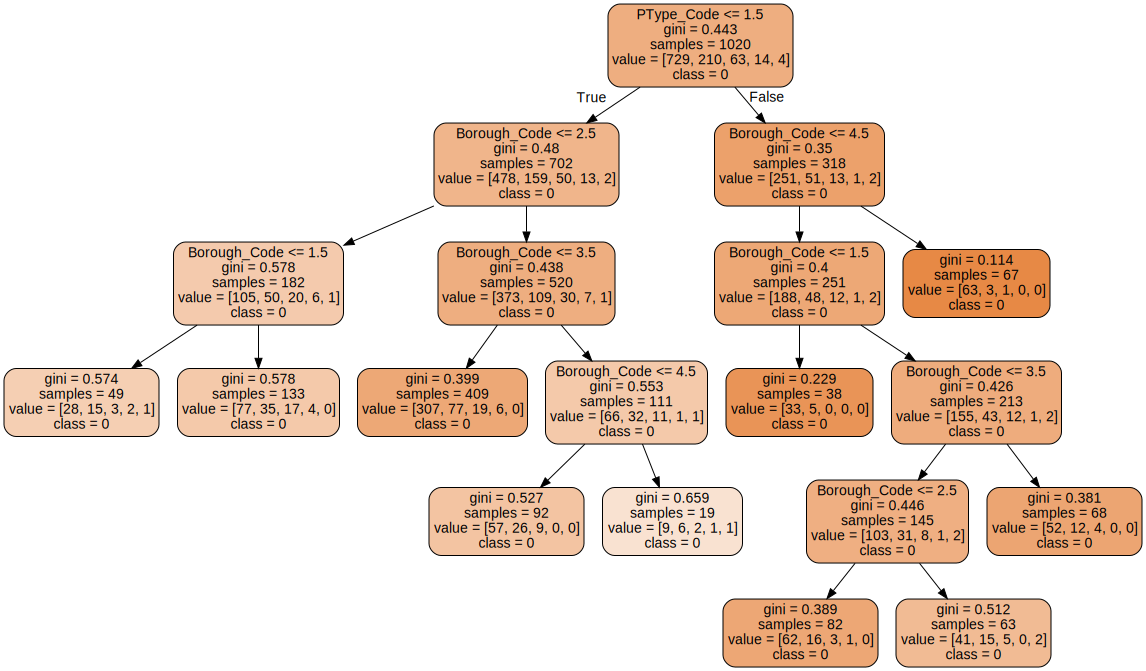

In [34]:
Source.from_file(os.path.join(IMAGES_PATH, "pool_tree_new.dot"))

**Conclusion**:

According to the results of the tests, it IS possible to predict how many critical violations will occur based on location data using decision trees, but the results are not very accurate.

With a max depth of 6, using most precise features like X any Y map coordinates, yielded only a correct prediction percentage of around 64%. Including the feature of permit type increased the percentage slightly, but adding zip code or borough decreased it instead. Unexpectedly, using the most impercise features, permit type and borough code, yielded the highest percentage, 67~68%. 

This indicates that whether the pools are indoor or outdoor, as describe by their permit type, have a relatively high influence on whether they have less or more critical violations. 